https://www.thepythoncode.com/article/finetuning-bert-using-huggingface-transformers-python

In [1]:
!pip3 install transformers numpy torch sklearn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from sklearn.metrics import plot_confusion_matrix, accuracy_score, plot_roc_curve, confusion_matrix
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
import string
nltk.download([
     "names",
     "stopwords",
     "vader_lexicon",
     "punkt",
 ])
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.metrics import confusion_matrix, accuracy_score, plot_roc_curve, confusion_matrix
import seaborn as sns
import torch
from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
from transformers import BertTokenizerFast, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
import numpy as np
import random
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package names to
[nltk_data]     C:\Users\Albert\AppData\Roaming\nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Albert\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Albert\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Albert\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
train_url = 'https://raw.githubusercontent.com/thiagorainmaker77/liar_dataset/master/train.tsv'
val_url = 'https://raw.githubusercontent.com/thiagorainmaker77/liar_dataset/master/valid.tsv'
test_url = 'https://raw.githubusercontent.com/thiagorainmaker77/liar_dataset/master/test.tsv'

train = pd.read_csv(train_url, delimiter='\t', header=None)
val = pd.read_csv(val_url, delimiter='\t', header=None)
test = pd.read_csv(test_url, delimiter='\t', header=None)
rename_columns = ['ID', 'label', 'statement', 'subjects', 'speaker', 'speaker_job_title', 'state_info',
                  'party_affiliation', 'barely_true', 'false', 'half_true', 'mostly_true', 'pants_on_fire',
                  'context'
                 ]
train.columns = rename_columns
val.columns = rename_columns
test.columns = rename_columns
all_data = pd.concat([train, val, test])

In [4]:
drop_columns = ['ID']
train.drop(drop_columns, axis=1, inplace = True)
train['speaker_job_title'].fillna('none', inplace=True) # temporary until I find better way
train['state_info'].fillna('none', inplace=True) # temporary until I find better way
train['context'].fillna('', inplace = True)
train.dropna(axis=0, how='any', subset=['subjects'], inplace=True)
train.dropna(axis=0, how='any', subset=['speaker'], inplace=True)
train.dropna(axis=0, how='any', subset=['party_affiliation'], inplace=True)
train = train.reset_index(drop=True)

val.drop(drop_columns, axis=1, inplace = True)
val['speaker_job_title'].fillna('none', inplace=True) # temporary until I find better way
val['state_info'].fillna('none', inplace=True) # temporary until I find better way
val['context'].fillna('', inplace = True)
val.dropna(axis=0, how='any', subset=['subjects'], inplace=True)
val.dropna(axis=0, how='any', subset=['speaker'], inplace=True)
val.dropna(axis=0, how='any', subset=['party_affiliation'], inplace=True)
val = val.reset_index(drop=True)

test.drop(drop_columns, axis=1, inplace = True)
test['speaker_job_title'].fillna('none', inplace=True) # temporary until I find better way
test['state_info'].fillna('none', inplace=True) # temporary until I find better way
test['context'].fillna('', inplace = True)
test.dropna(axis=0, how='any', subset=['subjects'], inplace=True)
test.dropna(axis=0, how='any', subset=['speaker'], inplace=True)
test.dropna(axis=0, how='any', subset=['party_affiliation'], inplace=True)
test = test.reset_index(drop=True)

In [5]:
def pre_process_text(text):
  text = text.lower()
  text_p = "".join([char for char in text if char not in string.punctuation])

  words = word_tokenize(text_p)

  stop_words = stopwords.words('english')
  filtered_words = [word for word in words if word not in stop_words]

  # porter = PorterStemmer()
  # stemmed = [porter.stem(word) for word in filtered_words]
  
  # pos = pos_tag(filtered_words)
  
  return ' '.join(filtered_words)

In [6]:
def set_seed(seed: int):
    """
    Helper function for reproducible behavior to set the seed in ``random``, ``numpy``, ``torch`` and/or ``tf`` (if
    installed).

    Args:
        seed (:obj:`int`): The seed to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    if is_torch_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # ^^ safe to call this function even if cuda is not available
    if is_tf_available():
        import tensorflow as tf

        tf.random.set_seed(seed)

In [7]:
set_seed(1)

In [8]:
# the model we gonna train, base uncased BERT
# check text classification models here: https://huggingface.co/models?filter=text-classification
model_name = "bert-base-uncased"
# max sequence length for each document/sentence sample
max_length = 512

In [9]:
# load the tokenizer
tokenizer = BertTokenizerFast.from_pretrained(model_name, do_lower_case=True)

Attempt 1 - Binary Classification

Attempt 2 - BERT multi classification

Attempt 3 - load Attempt 2 

In [10]:
label_map = {'false': 0, 'half-true': 0, 'mostly-true': 1, 'true': 1, 'barely-true': 0, 'pants-fire': 0}

X_train = train.drop(['speaker_job_title', 'state_info'], axis=1)
X_train = X_train[X_train['statement'].str.split().str.len().lt(300)]
X_train.dropna(axis=0, how='any', subset=['statement'], inplace=True)
y_train = X_train['label'].map(label_map)
y_train = y_train.astype('int64')
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)


X_val = val.drop(['speaker_job_title', 'state_info'], axis=1)
X_val = X_val[X_val['statement'].str.split().str.len().lt(300)]
X_val.dropna(axis=0, how='any', subset=['statement'], inplace=True)
y_val = X_val['label'].map(label_map)
y_val = y_val.astype('int64')
X_val = X_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

X_test = test.drop(['speaker_job_title', 'state_info'], axis=1)
X_test = X_test[X_test['statement'].str.split().str.len().lt(300)]
X_test.dropna(axis=0, how='any', subset=['statement'], inplace=True)
y_test = X_test['label'].map(label_map)
y_test = y_test.astype('int64')
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [11]:
# tokenize the dataset, truncate when passed `max_length`, 
# and pad with 0's when less than `max_length`
train_encodings = tokenizer(list(X_train['statement']), truncation=True, padding=True, max_length=max_length)
valid_encodings = tokenizer(list(X_val['statement']), truncation=True, padding=True, max_length=max_length)

In [12]:
class LiarDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor([self.labels[idx]])
        return item

    def __len__(self):
        return len(self.labels)

# convert our tokenized data into a torch Dataset
train_dataset = LiarDataset(train_encodings, y_train)
valid_dataset = LiarDataset(valid_encodings, y_val)

In [13]:
target_names = ['false', 'true']
# load the model and pass to CUDA
model = BertForSequenceClassification.from_pretrained('./', local_files_only=True, num_labels=len(target_names))

In [14]:
def get_prediction(text):
    # prepare our text into tokenized sequence
    inputs = tokenizer(text, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
    # perform inference to our model
    outputs = model(**inputs)
    # get output probabilities by doing softmax
    #probs = outputs[0].softmax(1)
    # executing argmax function to get the candidate label
    return outputs.logits

In [19]:
k = get_prediction(X_train['statement'][:3000])
print(k)

AssertionError: text input must of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).

In [16]:
import torch.nn.functional as F

In [67]:
test_pred_3 = []
for x in range (1 , 15):
    #print(torch.cuda.memory_summary(device=None, abbreviated=False))
    test_pred_3 += [F.softmax(get_prediction(text), dim = -1)for text in np.array(X_test['statement'][(x-1)*100:x*100])]
# test_pred_3 = [label_map[x] for x in test_pred_3]
#torch.cuda.memory_summary(device=None, abbreviated=False)

In [64]:
print(test_pred_3)

[tensor([[0.9615, 0.0385]], grad_fn=<SoftmaxBackward>), tensor([[0.5982, 0.4018]], grad_fn=<SoftmaxBackward>), tensor([[0.8630, 0.1370]], grad_fn=<SoftmaxBackward>), tensor([[0.8987, 0.1013]], grad_fn=<SoftmaxBackward>), tensor([[0.9365, 0.0635]], grad_fn=<SoftmaxBackward>), tensor([[0.1360, 0.8640]], grad_fn=<SoftmaxBackward>), tensor([[0.9198, 0.0802]], grad_fn=<SoftmaxBackward>), tensor([[0.9508, 0.0492]], grad_fn=<SoftmaxBackward>), tensor([[0.9706, 0.0294]], grad_fn=<SoftmaxBackward>), tensor([[0.9435, 0.0565]], grad_fn=<SoftmaxBackward>), tensor([[0.8129, 0.1871]], grad_fn=<SoftmaxBackward>), tensor([[0.9207, 0.0793]], grad_fn=<SoftmaxBackward>), tensor([[0.1912, 0.8088]], grad_fn=<SoftmaxBackward>), tensor([[0.8857, 0.1143]], grad_fn=<SoftmaxBackward>), tensor([[0.9694, 0.0306]], grad_fn=<SoftmaxBackward>), tensor([[0.9489, 0.0511]], grad_fn=<SoftmaxBackward>), tensor([[0.9491, 0.0509]], grad_fn=<SoftmaxBackward>), tensor([[0.0686, 0.9314]], grad_fn=<SoftmaxBackward>), tensor([[

In [ ]:
test_pred_3 = [x.tolist()[0] for x in test_pred_3]
# print(test_pred_3)
falseSM = [x[0] for x in test_pred_3]
trueSM = [x[1] for x in test_pred_3]
# print(falseSM[2])

In [66]:
df = pd.DataFrame()
df['FalseSM'] = falseSM
df['TrueSM'] = trueSM
df.to_csv('Logits_Test.csv')

Test accuracy: 0.6627172195892576
[[639 178]
 [249 200]]
1266


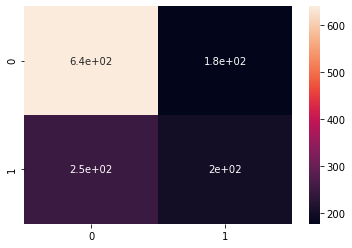

In [17]:
test_acc_score = accuracy_score(y_test, test_pred_3)
print(f'Test accuracy: {test_acc_score}')
mat = confusion_matrix(y_test, test_pred_3)
sns.heatmap(mat, annot=True)

print(mat)
sum = 0
for x in mat:
    sum+=np.sum(np.array(x))
print(sum)
#antipog

Generate Logits for Catboost

In [18]:
catboost_train_pred = [get_prediction(text) for text in np.array(X_train['statement'])]
print(catboost_train_pred)


[tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='c

In [20]:
print(model.logits)

ModuleAttributeError: 'BertForSequenceClassification' object has no attribute 'logits'